### PREDICTING WITH WAVELET SCATTERING
___

In [316]:
import os
import spectrai as spa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, resample

from kymatio.numpy import Scattering1D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, models, Model
import tensorflow.keras.backend as K
import tensorflow.keras.utils as utils
#from tensorflow.keras.utils import plot_model, normalize

from sklearn.ensemble import RandomForestRegressor

%load_ext autoreload
%autoreload 2
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utilities functions

In [317]:
def preprocess(x):
    x = x[:,:-1]
    x /= np.abs(x).max()
    return x

def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

def get_scattering_coeffs(x, J=4, Q=30):
    T = x.shape[-1]

    scattering = Scattering1D(J, T, Q)
    Sx = scattering(x)

    meta = scattering.meta()
    order0 = np.where(meta['order'] == 0)
    order1 = np.where(meta['order'] == 1)
    order2 = np.where(meta['order'] == 2)
    return [Sx[order0][0], Sx[order1], Sx[order2]]

def get_analyte(y, names, name):
    list(y_names).index(name)
    return y[:,list(y_names).index(name)]

### Data loading

In [318]:
DATA_PATH = os.path.join('..', 'data')
VIETNAM_PATH =  os.path.join('vnm-petra', 'mir-models')
DATA_URL = os.path.join(DATA_PATH, VIETNAM_PATH, '*.*')
VIETNAM_MEAS_URL = os.path.join(DATA_PATH, 'vnm-petra', 'mir-models', '20090215-soil-database-mirs.xls')

X, X_names, y, y_names, instances_id, _ = spa.load_data_petra(DATA_URL, VIETNAM_MEAS_URL)
print('X shape: ', X.shape)
print(y_names)
print(instances_id)

X shape:  (130, 1763)
['TC' 'TOC' 'TIC' 'TN' 'CEC' 'K' 'FCAVER' 'FCIAVER' 'FSAAVER']
['Av001' 'Av003' 'Av005' 'Av008' 'Av013' 'Av014' 'Av018' 'Av020' 'Av023'
 'Av026' 'Av027' 'Av032' 'Av036' 'Av038' 'Av040' 'Av041' 'Av042' 'Av043'
 'Av045' 'Av048' 'Av051' 'Av057' 'Av061' 'Av062' 'Av063' 'Av064' 'Av065'
 'Av067' 'Av069' 'Av072' 'Av077' 'Av080' 'Av083' 'Av086' 'Av092' 'Av098'
 'Av100' 'Av102' 'Av105' 'Av106' 'Av108' 'Av110' 'Av113' 'Av121' 'Av127'
 'Av133' 'Av139' 'Av141' 'Av143' 'Av146' 'Av147' 'Av149' 'Av152' 'Av155'
 'Av161' 'Av165' 'Av169' 'Av171' 'Av174' 'Av175' 'Av177' 'Av180' 'Av183'
 'Av189' 'Av195' 'Av203' 'Av205' 'Av208' 'Av209' 'Av211' 'Av214' 'Av217'
 'Av225' 'Av226' 'Av235' 'Av239' 'Av242' 'Av244' 'Av246' 'Av247' 'Av249'
 'Av252' 'Av255' 'Av261' 'Av265' 'Av267' 'Av268' 'Av272' 'Av365' 'Av366'
 'Av367' 'Av368' 'Av369' 'Av370' 'Av371' 'Av372' 'Av373' 'Av374' 'Av375'
 'Av376' 'Av377' 'Av378' 'Av379' 'Av380' 'F1 1.1A' 'F1 1.1B' 'F1 1.3A'
 'F1 1.3B' 'F1 1.6A' 'F1 1.6B' 'F1 2.3' '

### RF + wavelet scattering

#### Predicting Potassium (K)

* **No scattering**

In [84]:
# On an difficult one
# Removing NaN first
is_not_nan_idx = np.argwhere(~np.isnan(y).any(axis=1)).ravel()

X_not_nan = X[is_not_nan_idx,:]
y_not_nan = y[is_not_nan_idx,:]

NB_ITER = 20
test_r2s = np.zeros(NB_ITER)

for i in range(NB_ITER):
    X_train, X_test, y_train, y_test = train_test_split(X_not_nan, y_not_nan, test_size=0.20)
    analyte = 'K'

    y_train_analyte = get_analyte(y_train, y_names, analyte)
    y_test_analyte = get_analyte(y_test, y_names, analyte)


    rnd_reg = RandomForestRegressor(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)

    rnd_reg.fit(X_train, y_train_analyte)

    y_c = rnd_reg.predict(X_train)
    y_t_hat = rnd_reg.predict(X_test)

    y_cv = cross_val_predict(rnd_reg, X_train, y_train_analyte, cv=20)

    score_c = r2_score(y_train_analyte, y_c)
    score_cv = r2_score(y_train_analyte, y_cv)
    score_t_hat = r2_score(y_test_analyte, y_t_hat)
    test_r2s[i] = score_t_hat
    print('R2 on calibration: ', score_c)
    print('R2 on validation: ', score_cv)
    print('R2 on test set: ', score_t_hat)
    print('*' * 80)

R2 on calibration:  0.9688136198175206
R2 on validation:  0.7951512951194382
R2 on test set:  0.6418212019875951
********************************************************************************
R2 on calibration:  0.9479536702921632
R2 on validation:  0.6757767900667337
R2 on test set:  0.5813474895223653
********************************************************************************
R2 on calibration:  0.949220819657893
R2 on validation:  0.6616456295331417
R2 on test set:  0.5928652540095993
********************************************************************************
R2 on calibration:  0.9509323840638664
R2 on validation:  0.7047905408429691
R2 on test set:  0.7632063715720406
********************************************************************************
R2 on calibration:  0.9561402231843891
R2 on validation:  0.7468837355024174
R2 on test set:  0.7037528963158279
********************************************************************************
R2 on calibration:  0.969541984

In [85]:
np.mean(test_r2s)

0.6848892738783174

In [86]:
np.std(test_r2s)

0.09758985976031866

In [ ]:
# Visualizing feature importance
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(15,4))
    ax.set_xlim(4000, 600)
    _ = ax.plot(X_names, rnd_reg.feature_importances_)

* **With Wavelets scattering**

In [319]:
x = preprocess(X)

In [320]:
#spectrum_id = 91
J = 4 # Default 4 - when J increases, it decreases time resolution and have more translation-invariant properties
Q = 12 # Default 30
T = x.shape[-1]

In [321]:
x.shape

(130, 1762)

In [47]:
scattering = Scattering1D(J, T, Q)

In [48]:
Sx = scattering(x)

In [66]:
Sx.shape

(130, 65, 111)

In [144]:
meta = scattering.meta()
order0 = meta['order'] == 0
order1 = meta['order'] == 1
order2 = meta['order'] == 2

In [147]:
Sx[:,order0,:].shape

(130, 1, 111)

In [364]:
def flatten_coeffs(coeffs):
    shape_old = coeffs.shape
    batch_size = shape_old[0]
    return coeffs.reshape((batch_size, -1))

def unflatten_coeffs(coeffs, shape_old):
    return coeffs.reshape(shape_old)

def prune_coeffs(coeffs, ratio=0.95):
    mask = coeffs <= np.quantile(coeffs, ratio) 
    coeffs[mask] = 0
    return coeffs

def toScatter(X, J=4, Q=12, ratio=0.95, orders=[0,1,2]):
    x = preprocess(X)
    J = 4 # Default 4 - when J increases, it decreases time resolution and have more translation-invariant properties
    Q = 12 # Default 30
    T = x.shape[-1]
    scattering = Scattering1D(J, T, Q)
    Sx = scattering(x)
    
    meta = scattering.meta()
    order0 = meta['order'] == 0
    order1 = meta['order'] == 1
    order2 = meta['order'] == 2
    
    coeffs_flat = []
    
    for order in orders:
        if order == 0:
            coeffs_flat.append(flatten_coeffs(Sx[:,order0,:]))
        elif order == 1:
            coeffs_flat.append(prune_coeffs(flatten_coeffs(Sx[:,order1,:]), ratio=ratio))
        elif order == 2:
            coeffs_flat.append(prune_coeffs(flatten_coeffs(Sx[:,order2,:]), ratio=ratio))
            
    #coeffs_0_flat = flatten_coeffs(Sx[:,order0,:])
    #coeffs_1_flat = prune_coeffs(flatten_coeffs(Sx[:,order1,:]), ratio=ratio)
    #coeffs_2_flat = prune_coeffs(flatten_coeffs(Sx[:,order2,:]), ratio=ratio)
    #return np.c_[coeffs_0_flat, coeffs_1_flat, coeffs_2_flat]
    return np.concatenate(coeffs_flat, axis=1)

In [152]:
coeffs_0_flat = flatten_coeffs(Sx[:,order0,:])

In [153]:
coeffs_1_flat = prune_coeffs(flatten_coeffs(Sx[:,order1,:]))

In [154]:
coeffs_2_flat = prune_coeffs(flatten_coeffs(Sx[:,order2,:]))

In [155]:
coeffs_0_flat.shape

(130, 111)

In [156]:
coeffs_1_flat.shape

(130, 3108)

In [157]:
coeffs_2_flat.shape

(130, 3996)

In [159]:
coeffs_all_flat = np.c_[coeffs_0_flat, coeffs_1_flat, coeffs_2_flat]

In [162]:
coeffs_all_flat[0].shape[0]

7215

In [163]:
coeffs_all_flat[0].shape[0] - np.sum(coeffs_all_flat[0] == 0)

341

In [220]:
toScatter(X_not_nan, J=3, Q=12, ratio=0.9999)[0].shape

(29315,)

In [224]:
np.sum(toScatter(X_not_nan, J=3, Q=12, ratio=0.99)[0] != 0)

711

In [380]:
# On an difficult one
# Removing NaN first
is_not_nan_idx = np.argwhere(~np.isnan(y).any(axis=1)).ravel()

X_not_nan = X[is_not_nan_idx,:]
y_not_nan = y[is_not_nan_idx,:]

X_not_nan = toScatter(X_not_nan, J=3, Q=12, ratio=0.95, orders=[1,2])

print('# on non-zero coeffs', np.sum(X_not_nan[0] != 0))

X_train, X_test, y_train, y_test = train_test_split(X_not_nan, y_not_nan, test_size=0.20, random_state=3)
analyte = 'K'

y_train_analyte = get_analyte(y_train, y_names, analyte)
y_test_analyte = get_analyte(y_test, y_names, analyte)

rnd_reg = RandomForestRegressor(n_estimators=500, max_depth=10, max_leaf_nodes=16, n_jobs=-1)

rnd_reg.fit(X_train, y_train_analyte)

y_c = rnd_reg.predict(X_train)
y_t_hat = rnd_reg.predict(X_test)

y_cv = cross_val_predict(rnd_reg, X_train, y_train_analyte, cv=20)

score_c = r2_score(y_train_analyte, y_c)
score_cv = r2_score(y_train_analyte, y_cv)
score_t_hat = r2_score(y_test_analyte, y_t_hat)
print('R2 on calibration: ', score_c)
print('R2 on validation: ', score_cv)
print('R2 on test set: ', score_t_hat)

# on non-zero coeffs 289
R2 on calibration:  0.9520659455206922
R2 on validation:  0.6990450195292954
R2 on test set:  0.8078096552553735


| n_estimators  | pruning_ratio  | J  | # non-zero coeffs   | r2 (test)  | Coeffs | max_depth | random_state |
|---|---|---|---|---|---|---|---|
| 500  | 0.99  | 3  |  139 | 0.797  | 0,1,2| None | 42 |
| 500  | 0.9999  | 3  |  111 | 0.762  | 0,1,2| None | 42 |
| 500  | 0.99  | 3  |  139 | 0.805  | 0,1,2| 5 | 42 |
| 500  | 0.99  | 3  |  139 | 0.812  | 0,1,2| 10 | 42 |
| 500  | 0.99  | 3  |  139 | 0.807 | 0,1,2| 15 | 42 |
| 500  | 0.99  | 3  |  139 |  0.8 | 0,1,2| 20 | 42 |
| 500  | 0.99  | 3  |  139 | 0.68 | 0,1,2| 10 | 1 |
| 500  | 0.99  | 3  |  139 | 0.7 | 0,1,2| 10 | 2 |
| 500  | 0.99  | 3  |  139 | 0.82 | 0,1,2| 10 | 3 |
| 500  | 0.99  | 3  |  139 | 0.72 | 1,2| 10 | 3 |
| 500  | 0.99  | 3  |  28 | 0.44 | 1,2| 10 | 42 |
| 500  | 0.8  | 3  |  1208 | 0.67 | 1,2| 10 | 42 |
| 500  | 0.8  | 3  |  1208 | 0.8 | 1,2| 10 | 3 |
| 500  | 0.9  | 3  |  618 | 0.81 | 1,2| 10 | 3 |
| 500  | 0.95  | 3  |  289 | 0.83 | 1,2| 10 | 3 |
| 500  | 0.98  | 3  |  69 | 0.71 | 1,2| 10 | 3 |
| 500  | 0.97  | 3  |  117 | 0.71 | 1,2| 10 | 3 |
| 500  | 0.96  | 3  |  196 | 0.77 | 1,2| 10 | 3 |
| 500  | 0.99  | 3  |  139 | 0.75 | 0,1,2| 10 | 4 |



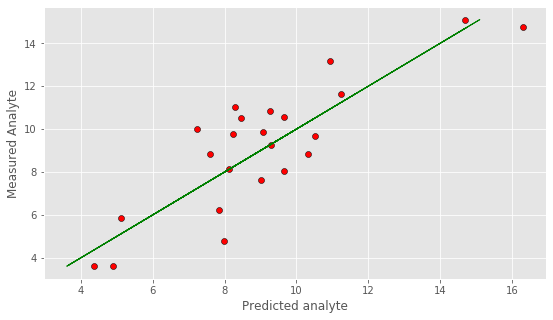

In [366]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_t_hat, y_test_analyte, c='red', edgecolors='k')
    ax.plot(y_test_analyte, y_test_analyte, color='green', linewidth=1)
    plt.xlabel('Predicted analyte')
    plt.ylabel('Measured Analyte')
    plt.show()

In [183]:
# On an easy one 'TOC'

X_scattered = toScatter(X, J=3, Q=12, ratio=0.95)
X_train, X_test, y_train, y_test = train_test_split(X_scattered, y, test_size=0.20, random_state=42)

analyte = 'TOC'

y_train_analyte = get_analyte(y_train, y_names, analyte)
y_test_analyte = get_analyte(y_test, y_names, analyte)

rnd_reg = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

rnd_reg.fit(X_train, y_train_analyte)

y_c = rnd_reg.predict(X_train)
y_t_hat = rnd_reg.predict(X_test)

y_cv = cross_val_predict(rnd_reg, X_train, y_train_analyte, cv=20)

score_c = r2_score(y_train_analyte, y_c)
score_cv = r2_score(y_train_analyte, y_cv)
score_t_hat = r2_score(y_test_analyte, y_t_hat)
print('R2 on calibration: ', score_c)
print('R2 on validation: ', score_cv)
print('R2 on test set: ', score_t_hat)

R2 on calibration:  0.9599839328992655
R2 on validation:  0.7629253355249028
R2 on test set:  0.6355028024759652


### Comparing with RF + raw data

R2 on calibration:  0.9585269567149935
R2 on validation:  0.7111316456435188
R2 on test set:  0.7649484507241583


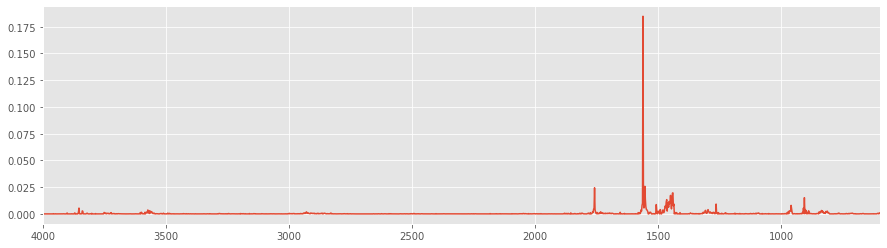

In [246]:
# On an difficult one
# Removing NaN first
is_not_nan_idx = np.argwhere(~np.isnan(y).any(axis=1)).ravel()

X_not_nan = X[is_not_nan_idx,:]
y_not_nan = y[is_not_nan_idx,:]

X_train, X_test, y_train, y_test = train_test_split(X_not_nan, y_not_nan, test_size=0.20, random_state=42)
analyte = 'K'
y_train_analyte = get_analyte(y_train, y_names, analyte)
y_test_analyte = get_analyte(y_test, y_names, analyte)

rnd_reg = RandomForestRegressor(n_estimators=500, max_depth=10, max_leaf_nodes=16, n_jobs=-1)

rnd_reg.fit(X_train, y_train_analyte)

y_c = rnd_reg.predict(X_train)
y_t_hat = rnd_reg.predict(X_test)

y_cv = cross_val_predict(rnd_reg, X_train, y_train_analyte, cv=20)

score_c = r2_score(y_train_analyte, y_c)
score_cv = r2_score(y_train_analyte, y_cv)
score_t_hat = r2_score(y_test_analyte, y_t_hat)
print('R2 on calibration: ', score_c)
print('R2 on validation: ', score_cv)
print('R2 on test set: ', score_t_hat)

# Visualizing feature importance
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(15,4))
    ax.set_xlim(4000, 600)
    _ = ax.plot(X_names, rnd_reg.feature_importances_)

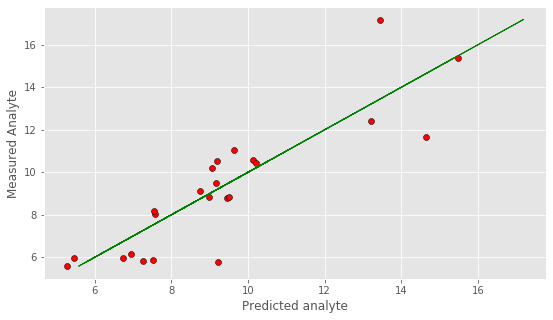

In [247]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_t_hat, y_test_analyte, c='red', edgecolors='k')
    ax.plot(y_test_analyte, y_test_analyte, color='green', linewidth=1)
    plt.xlabel('Predicted analyte')
    plt.ylabel('Measured Analyte')
    plt.show()

In [248]:
# Error analysis
np.abs(y_t_hat - y_test_analyte)

array([0.65585248, 0.46491547, 1.41627175, 1.11427148, 0.51228796,
       0.68058236, 0.32570905, 3.72994644, 3.43948085, 0.76764364,
       0.44083158, 1.41891829, 0.15609917, 1.33273862, 0.30233943,
       0.77738638, 0.65622683, 0.20324196, 0.38279869, 0.1053907 ,
       0.82529704, 2.98794788, 1.66672853])

In [266]:
worst_pred_id = np.argmax(np.abs(y_t_hat - y_test_analyte))
best_pred_id = np.argmin(np.abs(y_t_hat - y_test_analyte))

In [281]:
def preprocess_errors(x):
    x = x[:-1]
    x /= np.abs(x).max()
    return x.reshape(1, -1)

def get_scattering_coeffs_single(x, J=4, Q=30):
    T = x.shape[-1]

    scattering = Scattering1D(J, T, Q)
    Sx = scattering(x.ravel())

    meta = scattering.meta()
    order0 = np.where(meta['order'] == 0)
    order1 = np.where(meta['order'] == 1)
    order2 = np.where(meta['order'] == 2)
    return [Sx[order0][0], Sx[order1], Sx[order2]]

def vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label = 'Best', label_t = 'Preprocessed signal'):
    fig = plt.figure(constrained_layout=True, figsize=(16, 12))
    gs = fig.add_gridspec(nrows=6, ncols=2)

    ##############################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.title.set_text(label)
    ax1.plot(X_names[:-1], x.ravel(), color='firebrick')
    ax1.plot(X_names[:-1], x_t.ravel(), '--', linewidth=1, color='forestgreen')
    ax1.set_frame_on(False)
    ax1.set_xlim(4000, 600)

    #ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.title.set_text(label_t)
    #ax2.plot(X_names[:-1], x.ravel(), '--', linewidth=1, color='black')
    ax2.plot(X_names[:-1], x_t.ravel(), '--', linewidth=1, color='forestgreen')
    ax2.set_frame_on(False)
    ax2.set_xlim(4000, 600)
    #ax2.axis('off')


    ##############################################
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.title.set_text('Low pass filter: zeroth-order scattering')
    ax3.plot(Sx_coeffs[0])
    ax3.set_frame_on(False)
    ax3.set_xlim(0, len(Sx_coeffs[0]))

    ax4 = fig.add_subplot(gs[1, 1], sharex=ax3, sharey=ax3)
    ax4.plot(Sx_t_coeffs[0])
    ax4.axis('off')


    ##############################################
    ax5 = fig.add_subplot(gs[2:4, 0])
    ax5.title.set_text('First-order scattering')
    ax5.imshow(Sx_coeffs[1], aspect='auto')
    ax5.set_frame_on(False)
    #ax5.set_xlim(0, len(Sx_coeffs[1]))
    
    ax6 = fig.add_subplot(gs[2:4, 1], sharex=ax5, sharey=ax5)
    ax6.imshow(Sx_t_coeffs[1], aspect='auto')
    ax6.axis('off')

    ##############################################
    ax7 = fig.add_subplot(gs[4:6, 0])
    ax7.title.set_text('Second-order scattering')
    #ax7.set_xlim(0, len(Sx_coeffs[2]))
    ax7.set_frame_on(False)
    ax7.imshow(Sx_coeffs[2], aspect='auto')

    ax8 = fig.add_subplot(gs[4:6, 1], sharex=ax7, sharey=ax7)
    ax8.imshow(Sx_t_coeffs[2], aspect='auto')
    ax8.axis('off');

def vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t = 'Δs when preprocessed signal'):
    fig = plt.figure(constrained_layout=True, figsize=(16, 10))
    gs = fig.add_gridspec(nrows=6, ncols=2, width_ratios=(9.8, 0.2))
    
    fig.suptitle(label_t, fontsize=16)
    ##############################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.title.set_text('Δ signals')
    ax1.plot(X_names[:-1], x.ravel() - x_t.ravel(), color='firebrick')
    #ax1.plot(X_names[:-1], x_t.ravel(), '--', linewidth=1, color='forestgreen')
    ax1.set_frame_on(False)
    ax1.set_xlim(4000, 600)

    ##############################################
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.title.set_text('Δ low pass filter: zeroth-order scattering')
    ax3.plot(Sx_coeffs[0] - Sx_t_coeffs[0])
    ax3.set_frame_on(False)
    ax3.set_xlim(0, len(Sx_coeffs[0]))
        
    ##############################################
    ax5 = fig.add_subplot(gs[2:4, 0])
    ax5.title.set_text('Δ first-order scattering')
    im5 = ax5.imshow(np.abs(Sx_coeffs[1] - Sx_t_coeffs[1]), aspect='auto')
    ax5.set_frame_on(False)
    
    # colorbar
    cax5 = plt.subplot(gs[2:4,1])
    plt.colorbar(im5, cax=cax5, format='%.0e')
    

    ##############################################
    ax7 = fig.add_subplot(gs[4:6, 0])
    ax7.title.set_text('Δ second-order scattering')
    ax7.set_frame_on(False)
    im7 = ax7.imshow(np.abs(Sx_coeffs[2] - Sx_t_coeffs[2]), aspect='auto')
    
    # colorbar
    cax7 = plt.subplot(gs[4:6,1])
    plt.colorbar(im7, cax=cax7, format='%.0e')

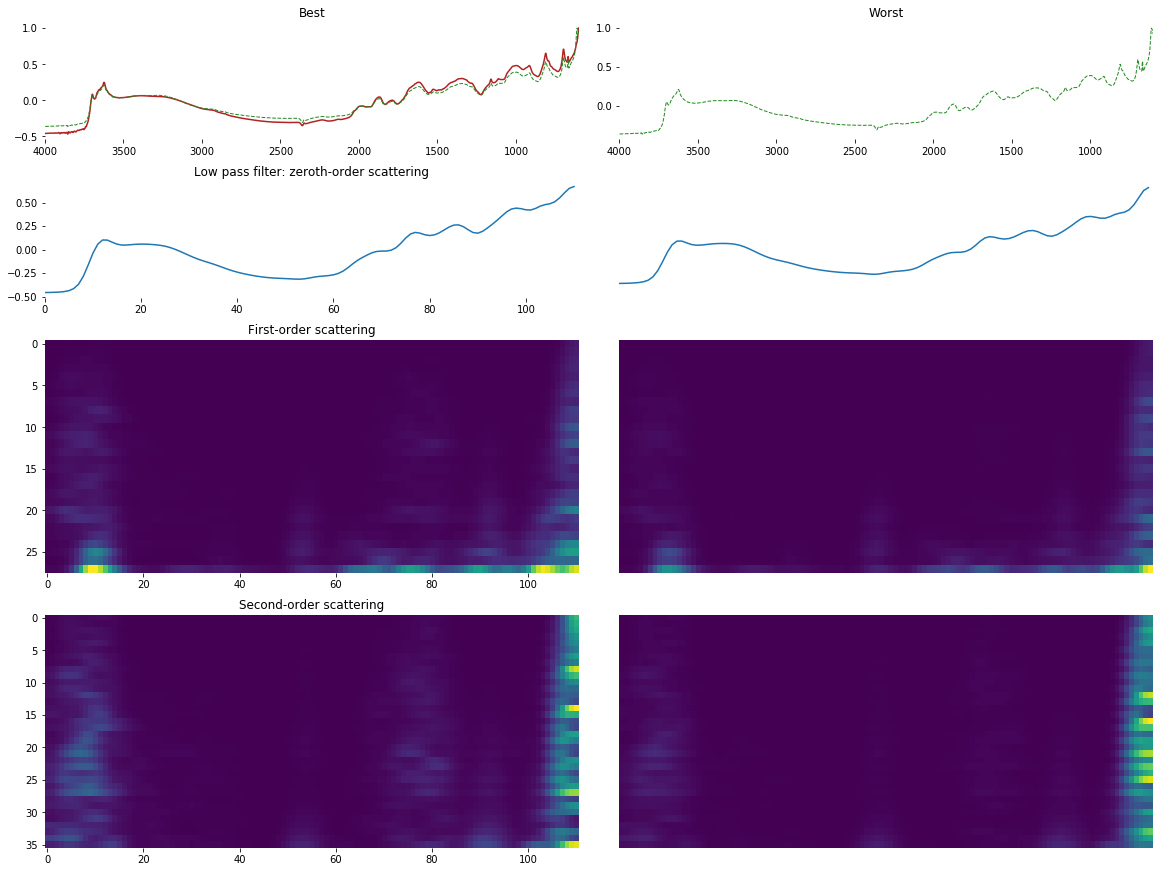

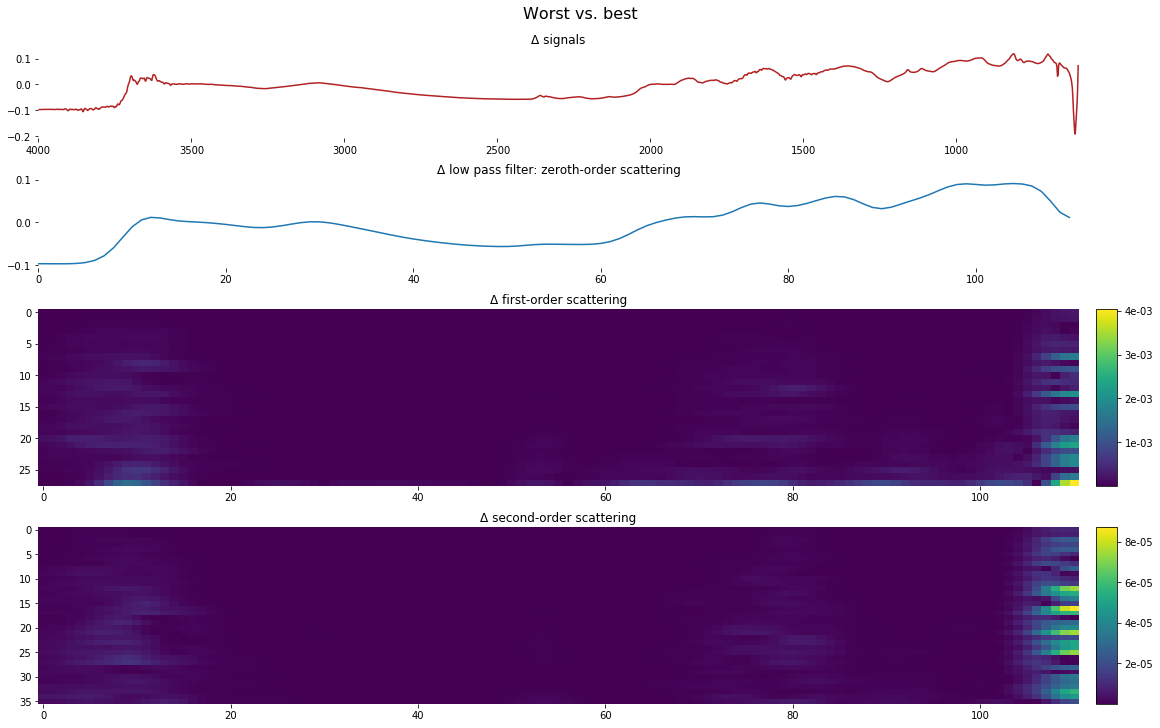

In [283]:
J = 4 # Default 4 - when J increases, it decreases time resolution and have more translation-invariant properties
Q = 12 # Default 30

x_best = preprocess_errors(X_test[best_pred_id])
x_worst = preprocess_errors(X_test[worst_pred_id])

Sx_best_coeffs = get_scattering_coeffs_single(x_best, J=J, Q=Q)
Sx_worst_coeffs = get_scattering_coeffs_single(x_worst, J=J, Q=Q)
vis_scattering(x_best, x_worst, Sx_best_coeffs, Sx_worst_coeffs, label_t='Worst')
vis_scattering_diff(x_best, x_worst, Sx_best_coeffs, Sx_worst_coeffs, label_t='Worst vs. best')